# Model Selection 
___

**Objective:** Select a model that can achieve a Mean Absolute Error of up to R$ 500 in mothly income prediction.  
 
- **MAE** was selected as the metric because it is easy to interpret and appropriate for the salary scenario.   
- The threshold of **R$ 500** was selected because it is reasonable for the data range and adds up to a prediction margin of R$ 1,000.   

**Process:**

1. Import libraries, modules, functions, classes, and the dataset
2. Train a baseline model and evaluate its performance
    - I'll use a default Random Forest because I think the reasoning to determine salary is similar to a tree-thought process.
    - Although it has robust internal mechanisms to generalize predictions, everytime I run the code, I'll test a different parameter that seems appropriate and will note fit time and performance
3. Train and optmize a boosting method to compare against bagging
    - I'll start with LightGBM because it's faster.
    - If necessary, I can use XGBoost or CatBoost
4. Evaluate whether a combination of models will work better than a single model
____

## 1. Importing

In [1]:
# Adding src to the path for modules
import sys
import os
root_path = os.path.abspath('..')
src_path = os.path.join(root_path, 'src')
sys.path.append(src_path)

# Project variables and functions
import config 
import utils
from preprocessing import pre_processing, divide_train_test
import importlib
importlib.reload(utils)

# Data manipulation
import pandas as pd
import numpy as np

# Models and metrics
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


Importing and dividing the data:

In [2]:
# Imports data and divide it into training and testing
X_train, X_test, y_train, y_test = divide_train_test(
    utils.read_compressed_data(config.COLLECTED_DATA_PATH),
    config.FEATURES,
    config.TARGET
)

# Shows first lines on X_train
X_train.head()

,state,age,sex,race,literate,highest_educational_level,years_studied,worker_type,work_segment,occupation_group,tax_payer,weekly_worked_hours,weekly_worked_hours_all_jobs
206997,DF,57,2,4,1,3,9,4,11,9,2,3,40
653228,CE,33,1,4,1,7,16,7,8,2,1,3,40
596722,PR,22,2,1,1,6,13,1,7,4,1,3,40
322304,BA,24,1,4,1,5,12,1,10,5,1,4,48
121644,AM,45,1,1,1,2,6,9,5,8,2,4,45


___

## 2. Baseline Model (Random Forest):

Notes:
- RandomForestRegressor(random_state=0) takes 7 min to fit and achieve a 790 MAE with 50% R²
- RandomForestRegressor(random_state=0, n_estimators=400) takes 40 min to fit and achieve a 786 MAE with 51% R²
- RandomForestRegressor(random_state=0, max_depth=8) takes 3 min to fit and achieve a 860 MAE with 45% R2
- RandomForestRegressor(random_state=0, max_depth=32) takes 8 min to fit and achieve a 788 MAE with 51% R²
- RandomForestRegressor(random_state=0, max_depth=24) takes 10 min to fit and achieve a 785 MAE with 52% R²
- RandomForestRegressor(random_state=0, min_samples_split=8) takes 6 min to fit and achieve a 787 MAE with 52% R²

In [11]:
# Creates a baseline pipeline using default random forest
baseline = Pipeline(
    steps=[
        ('pre_processing', pre_processing),
        ('model', RandomForestRegressor(random_state=0, min_samples_split=8))
    ]
)

# Fits 
baseline.fit(X_train, y_train)

Pipeline(steps=[('pre_processing',
                 Pipeline(steps=[('add region',
                                  AddFeature(existing_column='state',
                                             function=<function return_region at 0x0000011257A8E310>,
                                             new_feature_name='region')),
                                 ('add white mixed-race',
                                  AddFeature(existing_column='race',
                                             function=<function return_white_mixed_race at 0x0000011257A8E9D0>,
                                             new_feature_name='white_mixed_race')),
                                 ('add high schoo...
                                             function=<function discretize_weekly_worked_hours_all_jobs at 0x0000011257A8E8B0>,
                                             new_feature_name='weekly_worked_hours_v2')),
                                 ('add studied years',
                                  AddFeature(existing_column='years_studied',
                                             function=<function discretize_years_studied at 0x0000011257A8E940>,
                                             new_feature_name='studied_years_v2')),
                                 ('target encoder',
                                  CategoricalTargetEncoder())])),
                ('model',
                 RandomForestRegressor(min_samples_split=8, random_state=0))])

Evaluating Feature Importance:

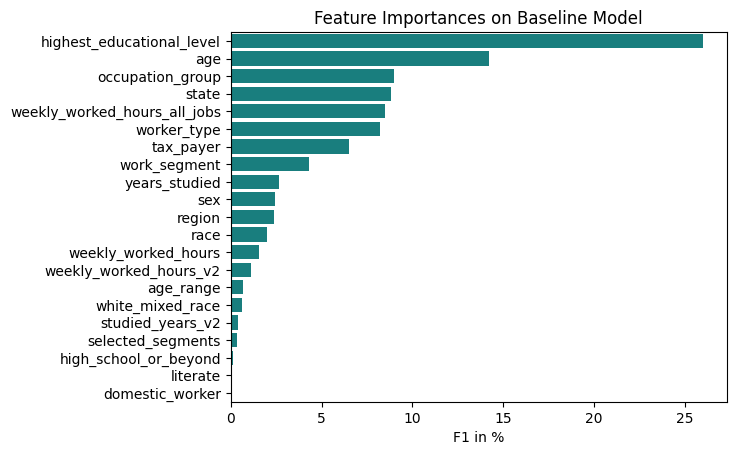

In [12]:
# Understand feature importances

# Starts with original features
features = list(X_train.columns)

# Appends new features
for i in range(len(baseline['pre_processing'])-1):
    features.append(baseline['pre_processing'][i].get_params()['new_feature_name'])

# Obtains feature importances and multiply by 100 to make a percentage
fi = np.array(baseline['model'].feature_importances_) * 100

# Combines everything in a Series
fi_series = pd.Series(fi, index=features)

# Sorts fi_series
fi_series.sort_values(ascending=False, inplace=True)

# Plots ranking
utils.show_barplot(
    cat=fi_series.index,
    values=fi_series,
    title='Feature Importances on Baseline Model',
    x_label='F1 in %'
)

Evaluating predictions with MAE and other complementary metrics:

In [13]:
baseline_pred = baseline.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, baseline_pred)}')
print(f'MAE: {mean_absolute_error(y_test, baseline_pred)}')
print(f'R²: {utils.make_percentage(r2_score(y_test, baseline_pred))}')

MSE: 1585832.5266136976
MAE: 787.2305331504068
R²:  52.27%


Trying with less features:

MSE: 1639563.5101964527
MAE: 790.4181642052876
R²:  50.65%


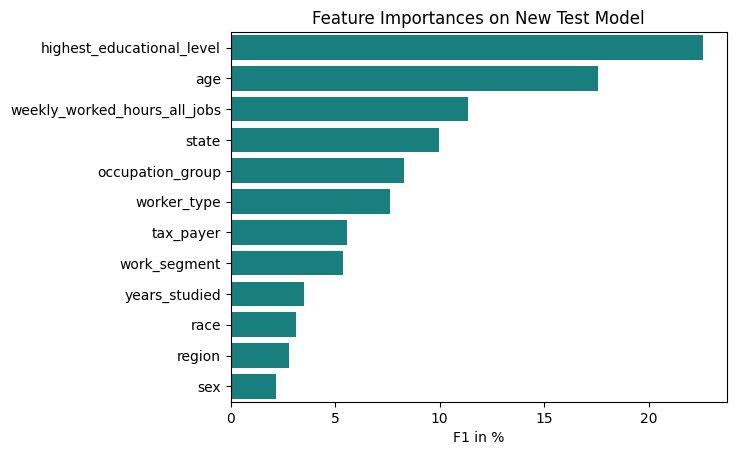

In [17]:
# Pre-process X_train and X_test
prep = pre_processing.fit(X_train, y_train)
prepX_train = prep.transform(X_train)
prepX_test = prep.transform(X_test)

# Subsets features using the first 12 features ranked by FI
less_features = list(fi_series[:12].index)

# Test training and predicting with less features
test_model = RandomForestRegressor(random_state=0)
test_model.fit(prepX_train[less_features], y_train)
test_preds = test_model.predict(prepX_test[less_features])

print(f'MSE: {mean_squared_error(y_test, test_preds)}')
print(f'MAE: {mean_absolute_error(y_test, test_preds)}')
print(f'R²: {utils.make_percentage(r2_score(y_test, test_preds))}')

# Obtains feature importances and multiply by 100 to make a percentage
new_fi = np.array(test_model.feature_importances_) * 100

# Combines everything in a Series
new_fi_series = pd.Series(new_fi, index=less_features)

# Sorts fi_series
new_fi_series.sort_values(ascending=False, inplace=True)

# Plots ranking
utils.show_barplot(
    cat=new_fi_series.index,
    values=new_fi_series,
    title='Feature Importances on New Test Model',
    x_label='F1 in %'
)

**In Summary:**
- A simple Random Forest performs relatively well, but does not achieve the expected MAE.
- Some features almost have no importance to the algorithm as it extracts more information from the original variables than the created ones.
___

## 3. Boosting Method (LightGBM)

Notes:
- LGBMRegressor(random_state=0) fits in 7 seconds, and achieves a 811 MAE with 50% R²
- Optmization for LGBMRegressor took 17 minutes to find the best estimator to have 200 estimators, 100 leaves, MAE 795, and R² of 52%.
- LGBMRegressor(random_state=0, n_estimators=300, num_leaves=100, force_row_wise=True) fits in 19 seconds, and achieves a 793 MAE with R² of 52%.

In [23]:
# Creates a pipeline
lgbm_pipeline = Pipeline(
    steps=[
        ('pre_processing', pre_processing),
        ('model', LGBMRegressor(random_state=0, n_estimators=300, num_leaves=100, force_row_wise=True))
    ]
)

# Fits
lgbm_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 578261, number of used features: 21
[LightGBM] [Info] Start training from score 2201.854054


Pipeline(steps=[('pre_processing',
                 Pipeline(steps=[('add region',
                                  AddFeature(existing_column='state',
                                             function=<function return_region at 0x0000011257A8E310>,
                                             new_feature_name='region')),
                                 ('add white mixed-race',
                                  AddFeature(existing_column='race',
                                             function=<function return_white_mixed_race at 0x0000011257A8E9D0>,
                                             new_feature_name='white_mixed_race')),
                                 ('add high schoo...
                                             function=<function discretize_weekly_worked_hours_all_jobs at 0x0000011257A8E8B0>,
                                             new_feature_name='weekly_worked_hours_v2')),
                                 ('add studied years',
                                  AddFeature(existing_column='years_studied',
                                             function=<function discretize_years_studied at 0x0000011257A8E940>,
                                             new_feature_name='studied_years_v2')),
                                 ('target encoder',
                                  CategoricalTargetEncoder())])),
                ('model',
                 LGBMRegressor(force_row_wise=True, n_estimators=300,
                               num_leaves=100, random_state=0))])

In [19]:
lgbm_pred = lgbm_pipeline.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, lgbm_pred )}')
print(f'MAE: {mean_absolute_error(y_test, lgbm_pred )}')
print(f'R²: {utils.make_percentage(r2_score(y_test, lgbm_pred ))}')

MSE: 1582912.8216424102
MAE: 792.6593582691141
R²:  52.36%


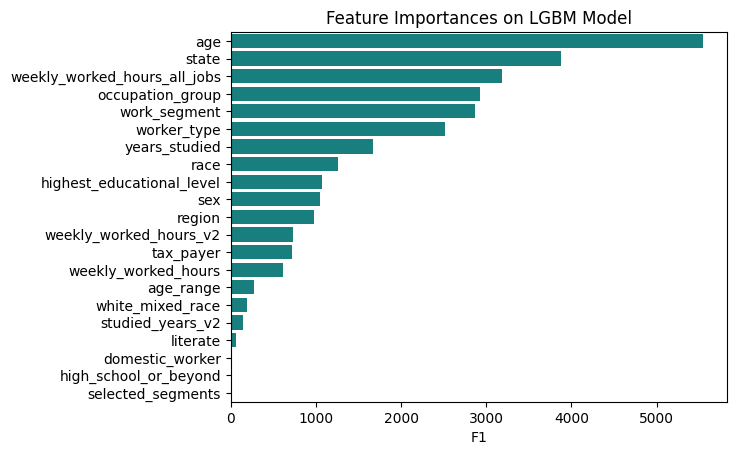

In [24]:
# Obtains feature importances and multiply by 100 to make a percentage
lgbm_fi = np.array(lgbm_pipeline['model'].feature_importances_)

# Combines everything in a Series
lgbm_fi_series = pd.Series(lgbm_fi, index=features)

# Sorts fi_series
lgbm_fi_series.sort_values(ascending=False, inplace=True)

# Plots ranking
utils.show_barplot(
    cat=lgbm_fi_series.index,
    values=lgbm_fi_series,
    title='Feature Importances on LGBM Model',
    x_label='F1'
)

Optmizing LightGBM with GridSearchCV as it has short fit time:

In [10]:
# Creates a param_grid
lgbm_params = {
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [50, 100, 200],
    'model__num_leaves': [31, 50, 100],
    'model__force_row_wise': [True]
}

# Creates the GridSearch
lgbm_grid_search = GridSearchCV(lgbm_pipeline, lgbm_params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

#Fits
lgbm_grid_search.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 578261, number of used features: 21
[LightGBM] [Info] Start training from score 2201.854054


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre_processing',
                                        Pipeline(steps=[('add region',
                                                         AddFeature(existing_column='state',
                                                                    function=<function return_region at 0x0000015BC933B310>,
                                                                    new_feature_name='region')),
                                                        ('add white mixed-race',
                                                         AddFeature(existing_column='race',
                                                                    function=<function return_white_mixed_race at 0x0000015BC933B9D0>,
                                                                    new_feature_name='white_...
                                                                    function=<function discretize_years_studied at 0x0000015BC933B940>,
                                                                    new_feature_name='studied_years_v2')),
                                                        ('target encoder',
                                                         CategoricalTargetEncoder())])),
                                       ('model',
                                        LGBMRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__force_row_wise': [True],
                         'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__n_estimators': [50, 100, 200],
                         'model__num_leaves': [31, 50, 100]},
             scoring='neg_mean_absolute_error')

In [17]:
# Understaning best model params
best_lgbm = lgbm_grid_search.best_estimator_
best_lgbm['model'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'num_leaves': 100,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'force_row_wise': True}

In [18]:
lgbm_pred = best_lgbm.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, lgbm_pred )}')
print(f'MAE: {mean_absolute_error(y_test, lgbm_pred )}')
print(f'R²: {utils.make_percentage(r2_score(y_test, lgbm_pred ))}')

MSE: 1591379.4303732717
MAE: 795.3111452950363
R²:  52.10%


**In Summary:**
- LightGBM was fast, but did not achieve expected MAE or performed better than Random Forest
- Further optmization can possibly be achieved increasing learning rate, n_estimators or num_leaves
_____

## 4. Combining Models

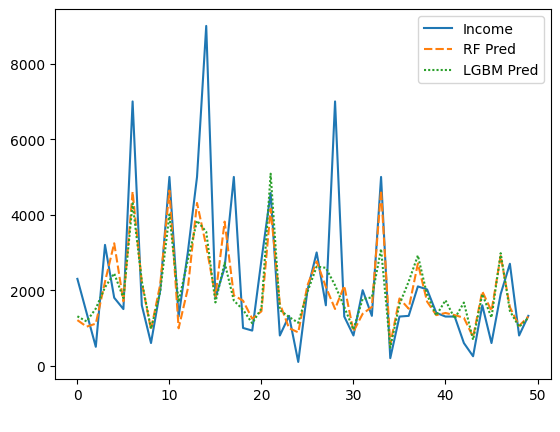

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns


# Sampling n observations
n = 50
sample = X_test.sample(n, random_state=0)
sample_y = y_test[sample.index]

# Predicting using models
rf_sample_pred = baseline.predict(sample)
lgbm_sample_pred = lgbm_pipeline.predict(sample)

# Constructs a DataFrame to compare
sample_pred_df = pd.DataFrame({'Income': sample_y, 'RF Pred': rf_sample_pred, 'LGBM Pred': lgbm_sample_pred})
sample_pred_df.index = list(range(n))
ax = sns.lineplot(data=sample_pred_df)
ax.set_xlabel(' ')
plt.show()

At least, the models learned to predict income variation

RF MAE: 819.6971232638671
LGBM MAE: 828.3531454695856


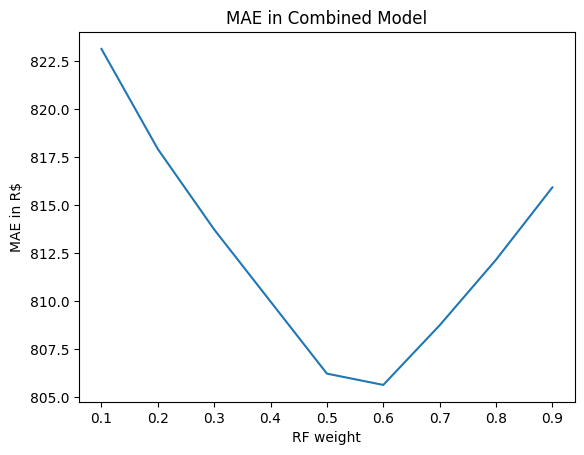

In [59]:
print(f'RF MAE: {mean_absolute_error(sample_y, rf_sample_pred)}')
print(f'LGBM MAE: {mean_absolute_error(sample_y, lgbm_sample_pred)}')

results = {}

# Initialize looping and changing rf_weight
for rf_weight in range(9, 0, -1):
    rf_weight = rf_weight / 10
    lgbm_weight = 1 - rf_weight

    weighted_pred = rf_sample_pred * rf_weight + lgbm_sample_pred * lgbm_weight
    results[rf_weight] = mean_absolute_error(sample_y, weighted_pred)

ax = sns.lineplot(data=results)
plt.title('MAE in Combined Model')
ax.set_ylabel('MAE in R$')
ax.set_xlabel('RF weight')
plt.show()
